In [1]:
# Connection to google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import tensorflow as tf
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, Flatten, Dropout, Activation
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from sklearn.metrics import classification_report, log_loss, accuracy_score

In [3]:
#source path for training data
source_path='/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image'

Training_DIR = os.path.join(source_path, 'training/segmented')
Validation_DIR = os.path.join(source_path, 'testing/segmented')

In [4]:
# Use the Image Data Generator to import the images from the dataset
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=30,
                                    zoom_range=0.2,
                                    shear_range=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
# Use the Image Data Generator to import the images from the dataset
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    rotation_range=30,
#                                    zoom_range=0.2,
#                                    width_shift_range=0.1,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2)

#test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(Training_DIR,
                                                 target_size = (256, 256),
                                                 batch_size = 1,
                                                 class_mode = 'categorical')

Found 2968 images belonging to 4 classes.


In [7]:
test_set = test_datagen.flow_from_directory(Validation_DIR,
                                            target_size = (256, 256),
                                            batch_size = 1,
                                            class_mode = 'categorical')

Found 600 images belonging to 4 classes.


In [8]:
# importing pretrained vgg16 model on local dataset
from tensorflow.keras.models import load_model
path1 = '/content/drive/MyDrive/rice_leaf_disease/colab/models/vgg16.h5'
path2 = '/content/drive/MyDrive/rice_leaf_disease/colab/models/vgg19.h5'
local_vgg16=load_model(path1)
local_vgg19=load_model(path2)


In [9]:
local_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [12]:
local_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D

# Create a new model with only convolutional layers up to block5_pool
model1 = Sequential()
for layer in local_vgg16.layers:
    if layer.name == 'block5_pool':
        break
    if isinstance(layer, Conv2D):
        layer.trainable = False
    model1.add(layer)
model1.add(local_vgg16.get_layer('block5_pool'))

model2 = Sequential()
for layer in local_vgg19.layers:
    if layer.name == 'block5_pool':
        break
    if isinstance(layer, Conv2D):
        layer.trainable = False
    model2.add(layer)
model2.add(local_vgg19.get_layer('block5_pool'))






In [14]:

# Create a new model using the outputs of the layer before flattening layer as inputs
#model1 = Model(inputs=local_vgg16.input, outputs=local_vgg16.get_layer("block5_pool").output)
#model2 = Model(inputs=local_vgg19.input, outputs=local_vgg19.get_layer("block5_pool").output)


# Transfer the learned weights from the original model to the new model
#model1.set_weights(model1.get_weights())
#model2.set_weights(model2.get_weights())

# Freeze all layers of the new model
#for layer in model1.layers:
#    layer.trainable = False

# Freeze all layers of the new model
##for layer in model2.layers:
 #   layer.trainable = False

In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [16]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Concatenate

# Create inputs for both models
inputs = tf.keras.Input(shape=(256, 256, 3), name='input_1')
#input_model2 = tf.keras.Input(shape=(256, 256, 3), name='input_model2')

# Get the output of model1
x = model1(inputs)
x = tf.keras.layers.Flatten()(x)

# Get the output of model2
y = model2(inputs)
y = tf.keras.layers.Flatten()(y)

# Concatenate the outputs of both models
z = Concatenate()([x, y])

# Add additional layers to the combined model
z = tf.keras.layers.Lambda(lambda z: tf.reshape(tf.transpose(tf.reshape(z, (1024, 64)), [1, 0]), (-1, 128, 512)))(z)
z = tf.keras.layers.LSTM(128, input_shape=(128, 512), batch_input_shape=(None, 128, 512))(z)
outputs = tf.keras.layers.Dense(4, activation='softmax')(z)

# Create a new model with the inputs and outputs
new_model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [18]:
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 8, 8, 512)    14714688    ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 8, 8, 512)    20024384    ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 32768)        0           ['sequential[0][0]']       

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#  the learning rate will be reduced by a factor of 0.1 if the validation loss does not improve after 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

from keras.callbacks import EarlyStopping
# Define a callback that stops training when the accuracy stops improving
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, min_delta=0.001, mode='max')

# compile the model
new_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy']
                  )

In [20]:
train = new_model.fit(training_set,
                validation_data = test_set, 
                epochs = 200, 
                steps_per_epoch = len(training_set),
                validation_steps = len(test_set),
                callbacks=[reduce_lr, early_stopping]
                )

Epoch 1/200
2968/2968 [==============================] - 929s 308ms/step - loss: 0.6533 - accuracy: 0.7369 - val_loss: 0.7158 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 2/200
2968/2968 [==============================] - 107s 36ms/step - loss: 0.4715 - accuracy: 0.8238 - val_loss: 0.3905 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 3/200
2968/2968 [==============================] - 97s 33ms/step - loss: 0.4349 - accuracy: 0.8389 - val_loss: 0.3628 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 4/200
2968/2968 [==============================] - 98s 33ms/step - loss: 0.3995 - accuracy: 0.8528 - val_loss: 0.3287 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 5/200
2968/2968 [==============================] - 99s 33ms/step - loss: 0.3725 - accuracy: 0.8689 - val_loss: 0.4290 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 6/200
2968/2968 [==============================] - 97s 33ms/step - loss: 0.3435 - accuracy: 0.8710 - val_loss: 0.3678 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 7/200
2968/2968 [==============

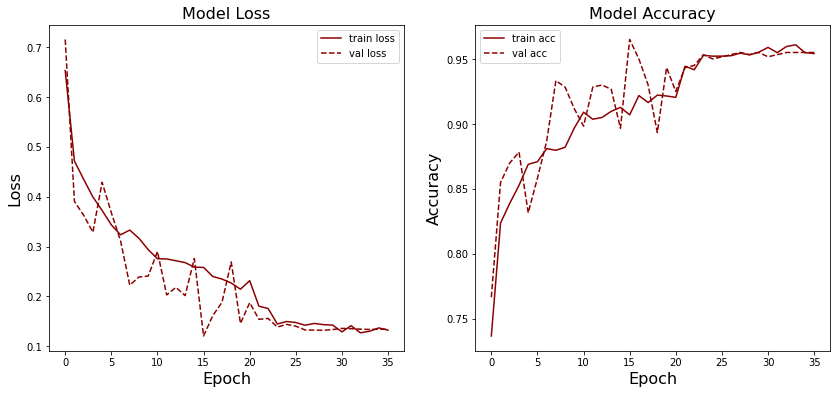

In [21]:
import matplotlib.pyplot as plt
# plot the loss
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
plt.plot(train.history['loss'], label='train loss', color = 'darkred')
plt.plot(train.history['val_loss'], label='val loss',linestyle='--', color = 'darkred')
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend()
#plt.show()


plt.subplot(1,2,2)
# plot the accuracy
plt.plot(train.history['accuracy'], label='train acc', color = 'darkred')
plt.plot(train.history['val_accuracy'], label='val acc', linestyle='--', color = 'darkred')
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend()
plt.show()

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# make predictions on the test set
y_pred = new_model.predict(test_set)

# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, thresholds = roc_curve(test_set.classes, y_pred[:, 1])

# calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()


600/600 [==============================] - 14s 22ms/step


ValueError: ignored

In [23]:
# save it as a h5 file
tf.keras.models.save_model(new_model, '/content/drive/MyDrive/rice_leaf_disease/colab/models/CNNs_lstm_segmented_image12.h5')

In [24]:
print("Final Train Accuracy:", train.history['accuracy'][-1])
print("Final Test Accuracy:", train.history['val_accuracy'][-1])
print("Final Train Loss:", train.history['loss'][-1])
print("Final Test Loss:", train.history['val_loss'][-1])

Final Train Accuracy: 0.9541779160499573
Final Test Accuracy: 0.9549999833106995
Final Train Loss: 0.1320987045764923
Final Test Loss: 0.13375510275363922


**uploading model for evaluation **

In [25]:
#!pip install pyyaml h5py  # Required to save models in HDF5 format
from tensorflow.keras.models import load_model
path = '/content/drive/MyDrive/rice_leaf_disease/colab/models/CNNs_lstm_segmented_image12.h5'
model_combined=load_model(path)

In [26]:
test_set = test_datagen.flow_from_directory(Validation_DIR,
                                            target_size = (256, 256),
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 600 images belonging to 4 classes.


In [27]:
y_pred = model_combined.predict(test_set)

600/600 [==============================] - 14s 22ms/step


<Figure size 432x288 with 0 Axes>

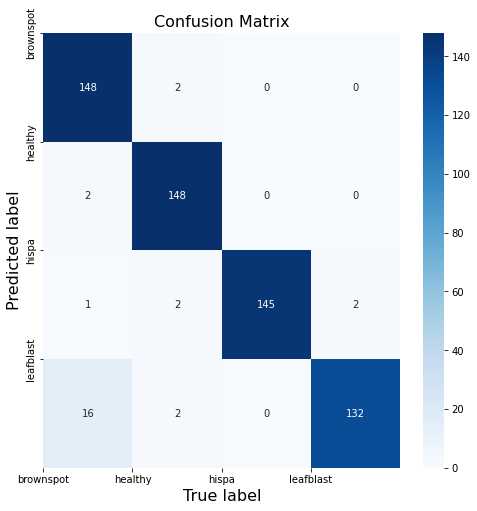

In [28]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from glob import glob

class_indices = test_set.classes
class_names = sorted(os.listdir(Validation_DIR))
#class_names = ['brownspot', 'healthy', 'hispa', 'leafblast']
class_dict = {i: name for i, name in enumerate(class_names)}
test_labels = [class_dict[i] for i in class_indices]
# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder on the original class labels
le.fit(test_labels)

# Transform the original class labels to numerical labels
encoded_test_labels = le.transform(test_labels)


predictions = np.argmax(y_pred, axis = 1)

cm = confusion_matrix(encoded_test_labels, predictions)
plt.figure()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
yticklabels = range(len(cm))
#ax.set_yticks(yticklabels)
#ax.set_yticklabels(yticklabels)
plt.xticks(np.arange(4), ['brownspot', 'healthy', 'hispa', 'leafblast'])
plt.yticks(np.arange(4), ['brownspot', 'healthy', 'hispa', 'leafblast'])
plt.xlabel('True label', fontsize=16)
plt.ylabel('Predicted label', fontsize=16)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


tp: 132.0

fp: 2.0

fn: 18.0
classes: [brownspot, healthy, hispa, leafblast]
Precision score per class: [0.8862275449101796, 0.961038961038961, 1.0, 0.9850746268656716]


Recall score per class:  [0.9866666666666667, 0.9866666666666667, 0.9666666666666667, 0.88]


F1 score per class:  [0.9337539432176656, 0.9736842105263157, 0.983050847457627, 0.9295774647887323]


classes: [brownspot, healthy, hispa, leafblast]
Precision score per class: [0.8862275449101796, 0.961038961038961, 1.0, 0.9850746268656716]


Recall score per class:  [0.9866666666666667, 0.9866666666666667, 0.9666666666666667, 0.88]


F1 score per class:  [0.9337539432176656, 0.9736842105263157, 0.983050847457627, 0.9295774647887323]




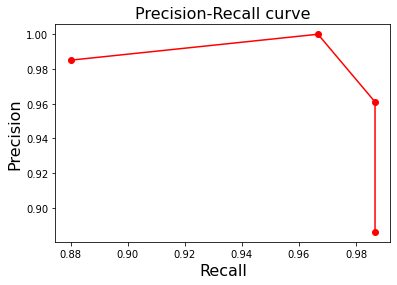

In [33]:
# Calculate precision for each class
precision = []
for i in range(4):
    true_positive = cm[i,i]
    false_positive = np.sum(cm[:,i]) - true_positive
    precision.append(true_positive / (true_positive + false_positive))

# Calculate recall for each class
recall = []
for i in range(4):
  tp = cm[i][i]
  fn = np.sum(cm[i, :]) - tp
  recall.append(tp / (tp + fn))

# Calculate F1 score for each class
f1 = []
for i in range(4):
    f1.append(2 * precision[i] * recall[i] / (precision[i] + recall[i]))


average_tp = np.mean(tp)
print("\ntp:", average_tp)
average_fp = np.mean(false_positive)
print("\nfp:", average_fp)
average_fn = np.mean(fn)
print("\nfn:", average_fn)
print("classes: [brownspot, healthy, hispa, leafblast]")
print("Precision score per class:", precision)
print("\n")
print("Recall score per class: ", recall)
print("\n")
print("F1 score per class: ", f1)
print("\n")

print("classes: [brownspot, healthy, hispa, leafblast]")
print("Precision score per class:", precision)
print("\n")
print("Recall score per class: ", recall)
print("\n")
print("F1 score per class: ", f1)
print("\n")

plt.plot(recall, precision, 'ro-')
plt.xlabel('Recall', fontsize = 16)
plt.ylabel('Precision', fontsize = 16)
plt.title('Precision-Recall curve', fontsize = 16)
plt.show()

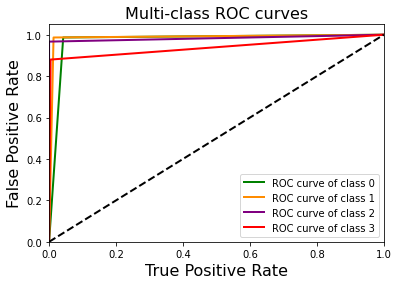

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Calculate the ROC curve for each class
fpr = {}
tpr = {}
#roc_auc = {}
n_classes = 4

y_true = encoded_test_labels #true data labels
y_scores = predictions #predicted scores

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=range(n_classes))
y_scores_bin = label_binarize(y_scores, classes=range(n_classes))

for i in range(n_classes):
    # Calculate the ROC curve for class i
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores_bin[:, i])
    #roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores_bin[:, i])
   
# Plot the ROC curves for all classes

colors = ['green', 'darkorange', 'purple', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0}'.format(i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('True Positive Rate', fontsize = 16)
plt.ylabel('False Positive Rate', fontsize = 16)
plt.title('Multi-class ROC curves', fontsize = 16)
plt.legend(loc="lower right")
plt.show()


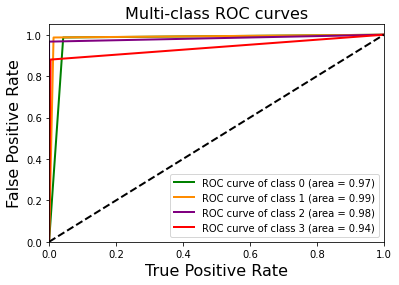

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Calculate the ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = 4

y_true = encoded_test_labels #true data labels
y_scores = predictions #predicted scores

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=range(n_classes))
y_scores_bin = label_binarize(y_scores, classes=range(n_classes))
#y_true_bin = np.resize(y_true, (4, 150))
for i in range(n_classes):
    # Calculate the ROC curve for class i
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores_bin[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_scores_bin[:, i])
    
# Plot the ROC curves for all classes
colors = ['green', 'darkorange', 'purple', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('True Positive Rate', fontsize = 16)
plt.ylabel('False Positive Rate', fontsize = 16)
plt.title('Multi-class ROC curves', fontsize = 16)
plt.legend(loc="lower right")
plt.show()


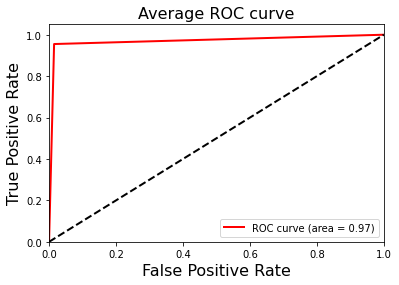

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Calculate the ROC curve for each class
n_classes = 4
y_true = encoded_test_labels #true data labels
y_scores = predictions #predicted scores

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=range(n_classes))
y_scores_bin = label_binarize(y_scores, classes=range(n_classes))

# Calculate the overall ROC curve using micro-average
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_scores_bin.ravel())
roc_auc = roc_auc_score(y_true_bin, y_scores_bin, average="micro")

# Plot the overall ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red', lw=lw,
         label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Average ROC curve', fontsize = 16)
plt.legend(loc="lower right")
plt.show()
